# Politisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

In [2]:
src = '../../data/tweets'
dst = '../../plots/politisation'

In [3]:
IchBinHanna_tweets = pd.read_csv(join(src, 'IchBinHanna.csv'), low_memory=False,
                        parse_dates=['created_at'])
IchBinHanna_tweets['created_at_date'] = IchBinHanna_tweets['created_at'].dt.date
IchBinHanna_tweets = IchBinHanna_tweets[\
        IchBinHanna_tweets['created_at_date'] >= pd.to_datetime('2021-01-01')]

In [4]:
HannaImBundestag_tweets = pd.read_csv(join(src, 'HannaImBundestag.csv'), low_memory=False,
                        parse_dates=['created_at'])
HannaImBundestag_tweets['created_at_date'] = HannaImBundestag_tweets['created_at'].dt.date
HannaImBundestag_tweets = HannaImBundestag_tweets[\
        HannaImBundestag_tweets['created_at_date'] >= pd.to_datetime('2021-01-01')]

In [5]:
hanna_tweets = pd.concat([IchBinHanna_tweets, HannaImBundestag_tweets])
hanna_tweets = hanna_tweets.sort_values(by=['created_at'])
hanna_tweets = hanna_tweets.reset_index(drop=True)

In [6]:
N = len(hanna_tweets)
hanna_tweets = hanna_tweets.drop_duplicates(subset=['id'])
print('dropped {} out of {} tweets, because they were duplicates'\
         .format(N - len(hanna_tweets), N))

dropped 4775 out of 70301 tweets, because they were duplicates


In [7]:
print('#IchBinHanna tweets remaining: {}'.format(len(hanna_tweets)))

#IchBinHanna tweets remaining: 65526


Frequency of hashtags that either mention the Bundestagswahl 2021 or strikes.

In [8]:
def extract_hashtags(tagstring):
    if tagstring == tagstring:
        list_of_dicts = eval(tagstring)
        hashtags = []
        for dct in list_of_dicts:
            tag = dct['tag']
            hashtags.append(tag)
        return hashtags
    else:
        return np.nan
    
def extract_mentions(mentionstring):
    if mentionstring == mentionstring:
        mentionstring = mentionstring.replace('false', 'False')
        mentionstring = mentionstring.replace('true', 'True')
        list_of_dicts = eval(mentionstring)
        usernames = []
        for dct in list_of_dicts:
            username = dct['username']
            usernames.append(username)
        return usernames
    else:
        return np.nan

In [9]:
pol_tags = {'Bundestagswahl2021', 'bundestagswahl2021', 'BUNDESTAGSWAHL2021',
            'BundesTagsWahl2021', 'BTW2021', 'btw2021', 'btw21', 'BTW21',
            'Bundestagswahl21', 'bundestagswahl21', 'BUNDESTAGSWAHL21'}
strike_tags = {'streik', 'STREIK', 'Streik'}

def check_political(taglist):
    if taglist == taglist:
        if len(pol_tags.intersection(set(taglist))) > 0:
            return 1
        else:
            return 0
    else:
        return np.nan
    
def check_strike(taglist):
    if taglist == taglist:
        if len(strike_tags.intersection(set(taglist))) > 0:
            return 1
        else:
            return 0
    else:
        return np.nan

In [10]:
hanna_tweets['hashtags'] = hanna_tweets['entities.hashtags'].apply(extract_hashtags)

hanna_tweets['mention_usernames'] = hanna_tweets['entities.mentions']\
        .apply(extract_mentions)

In [11]:
hanna_tweets['political'] = hanna_tweets['hashtags'].apply(check_political)
hanna_tweets['strike'] = hanna_tweets['hashtags'].apply(check_strike)

In [12]:
hanna_pol = hanna_tweets[['created_at_date', 'political', 'strike', 'id']]\
    .groupby('created_at_date')\
    .agg({'political':'sum', 'strike':'sum', 'id':'count'})\
    .reset_index()\
    .sort_values(by=['created_at_date'])\
    .reset_index(drop=True)\
    .rename(columns={'id':'tweet_count'})
hanna_pol.head(3)

,created_at_date,political,strike,tweet_count
0,2021-01-09,0.0,0.0,1
1,2021-01-11,0.0,0.0,1
2,2021-01-13,0.0,0.0,1


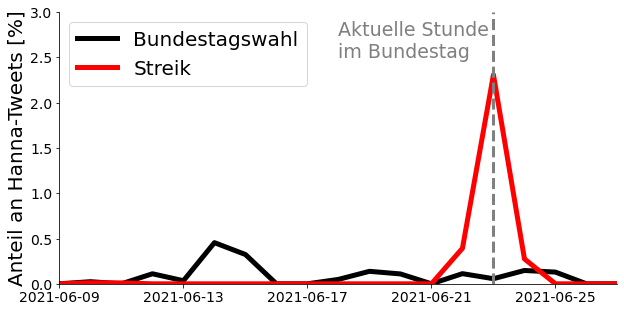

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

ymax = 3

hanna_pol['pol_ratio'] = hanna_pol['political'] / hanna_pol['tweet_count'] * 100
hanna_pol['strike_ratio'] = hanna_pol['strike'] / hanna_pol['tweet_count'] * 100

ax.plot(hanna_pol['created_at_date'], hanna_pol['pol_ratio'],
        label='Bundestagswahl', color='k', lw=5)
ax.plot(hanna_pol['created_at_date'], hanna_pol['strike_ratio'],
        label='Streik', color='r', lw=5)

ax.legend(loc=2, fontsize=20)

# note: need to shift debate date by one day due to how counts are assigned to 
# days by the Twitter API
debate_date = pd.to_datetime('2021-06-23')
ax.plot([debate_date, debate_date], [0, ymax], '--', color='grey', lw=3)
ax.text(pd.to_datetime('2021-06-18'), 2.5, 'Aktuelle Stunde\nim Bundestag',
        fontsize=19, color='grey')

dateticks = ['2021-06-09', '2021-06-13', '2021-06-17', '2021-06-21',
             '2021-06-25']
ax.set_xticks([pd.to_datetime(tick) for tick in dateticks])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(pd.to_datetime('2021-06-09'), pd.to_datetime('2021-06-27'))
ax.set_ylim(0, 3)
ax.set_ylabel('Anteil an Hanna-Tweets [%]', fontsize=20)

plt.savefig(join(dst, 'frequency_of_political_tweets.pdf'))
plt.savefig(join(dst, 'frequency_of_political_tweets.svg'))
plt.savefig(join(dst, 'frequency_of_political_tweets.png'), dpi=300)